In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from numpy import exp, array, random, dot
from skimage.io import imshow
import os

## Предобработка данных

In [3]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Разбиваем данные на обучающую и валидационую выборки
num_classes = 10
#Перемещиваем данные
idx = np.random.permutation(len(x_train))
data, tr_labels = x_train[idx], y_train[idx]
val_labels = y_test

# Делаем исходные картинки плоскими и формуриуем обучающую и валидационную выборки
tr_data = []
for i in range(len(data)):
    tr_data.append(data[i].flatten())

val_data = []
for i in range(len(x_test)):
    val_data.append(x_test[i].flatten())
    
tr_data = np.array(tr_data) 
val_data = np.array(val_data)    


#tr_data.shape, val_data.shape , idx

Using TensorFlow backend.


(784,)
8 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


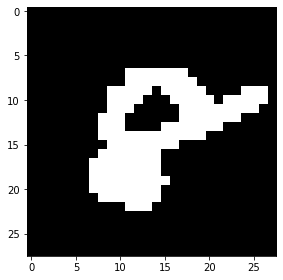

In [9]:
def scale(data):
    data[data>0] = 255
    return (data-np.min(data))/(np.max(data)-np.min(data))

def one_hotting_labels(labels,num_classes, instances):
    one_hot_labels = np.zeros((labels.shape[0], num_classes))

    for i in range(instances):
        one_hot_labels[i, labels[i]] = 1
        
    return one_hot_labels

X_val = np.float32(scale(val_data)) 
X_train = np.float32(scale(tr_data))
y_val = val_labels
y_train = tr_labels

instances = X_train.shape[0] #мощность обучающей выборки

attributes = X_train.shape[1] #количество признаков

one_hot_labels = one_hotting_labels(y_train,num_classes, instances)

print(X_train[0].shape)
print(y_train[0] ,one_hot_labels[0])
imshow(X_train[0].reshape((28,28)))


## Инициализация обучения

In [25]:
num_perceptrons = 100
num_classes = 10
lr = 1e-5
num_epochs= 200

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_der(x):
    return sigmoid(x) *(1-sigmoid (x))

def compute_loss(y_true, y_pred ):
    L_sum = np.sum(-1* y_true * np.log(y_pred + 1e-12))
    
    return L_sum
        
#y_true = np.array([0., 0., 1., 0., 0.])
#y_pred = np.array([0.3, 0.1 , 0.2 , 0.9, 0.6])

#compute_loss(y_true, y_pred)

In [26]:
def train(X_train,one_hot_labels,instances,attributes,num_perceptrons,num_classes,lr, num_epochs,X_val,y_val):
    
    weights_hidden = np.random.normal(0,0.1,(attributes,num_perceptrons)) #weights_hidden - веса на скрытом слое
    bias_hidden = np.random.normal(0,0.1,(num_perceptrons)) #bias_hidden - отклонение на скрытом слое

    weights_out = np.random.normal(0,0.1,(num_perceptrons, num_classes)) #weights_out - веса на выходном слое
    bias_out = np.random.normal(0,0.1,(num_classes)) #bias_out - отклонение на выходном слое

    LOSS_tr = []
    LOSS_val = []
    ACC_tr = []
    ACC_val = []

    for epoch in range(num_epochs):
        # Подсчет значений активации на скрытом слое
        #print(weights_out[0])
        value_hidden = np.dot(X_train, weights_hidden) + bias_hidden #значение в hidden
        activation_hidden = sigmoid(value_hidden) #функция активации в hidden
        # Подсчет значений активации на выходном слое
        value_out = np.dot(activation_hidden, weights_out) + bias_out #значение в out
        activation_out = sigmoid(value_out) #функция активации в out
        loss = compute_loss(one_hot_labels , activation_out)
        LOSS_tr.append(loss)
        ##################
        ### Back prop ####
        ##################
        #     print('loss ',loss)
        #     print('\n')
        #     print('activation_out ',activation_out[0])
        #     print('\n')
        #     print('activation_hidden ',activation_hidden[0])
        #     print('\n')

        #     print('value_out ',value_out[0])
        #     print('\n')
        #     print('value_hidden ',value_hidden[0])
        #     print('\n')

            ######### Фаза 1 Применение цепного правила для слоя out
        # d_cost / d_WO = d_cost / d_AO * d_AO / d_VO * d_VO / d_WO

        # d_cost / d_AO = d_(-y^ * log(AO) - (1-y^) * log((1-AO))) / d_AO = -y^ / AO - (1-y^) * (-1/(1-AO)) = -y^/AO + (1-y^)/(1-AO)

        # d_cost / d_VO = d_cost / d_AO * d_AO / d_VO = (-y^/AO + (1-y^)/(1-AO)) * sigmoid(VO) * (1-sigmoid(VO)) = 
        # = (-y^/AO + (1-y^)/(1-AO)) * AO * (1-AO) = (-y^ + (1-y^)*AO / (1-AO)) *(1-AO) = -y^ *(1 - AO) + (1-y^) * AO =
        # = -y^ + y^ * AO + AO - y^ * AO = -y^  + AO = AO - y^

        
        #print(value_hidden[0])
        d_cost_d_VO = (activation_out - one_hot_labels) #* sigmoid_der(value_out)
        #print('d_cost_d_VO ',d_cost_d_VO[0], d_cost_d_VO.shape)
        #print('\n')
        d_VO_d_WO = activation_hidden 
        #print('d_VO_d_WO ',d_VO_d_WO[0] , d_VO_d_WO.shape)
        #print('\n')
        d_cost_d_WO = np.dot(d_cost_d_VO.T , d_VO_d_WO).T
        #print('d_cost_d_WO ',d_cost_d_WO[0])
        #print('\n') 
        d_cost_d_BO = d_cost_d_VO.sum(axis=0)
        #print('d_cost_d_BO ',d_cost_d_BO[0])
        #print('\n')
        #print(weights_out)
        #############

        d_VO_d_AH = weights_out 
        d_AH_d_VH = sigmoid_der(value_hidden) 
        d_VH_d_WH = X_train 
        d_cost_d_AH = np.dot(d_cost_d_VO, d_VO_d_AH.T)
        d_cost_d_VH = d_cost_d_AH * d_AH_d_VH
        d_cost_d_WH = np.dot(d_cost_d_VH.T , d_VH_d_WH).T 
        d_cost_d_BH = d_cost_d_VH.sum(axis=0)

        weights_hidden -= lr * d_cost_d_WH #отнимает значение изменения ошибки от весов из весов, помноженное на коэффициент доверия
        bias_hidden -= lr * d_cost_d_BH # то же самое проделываем с байесом

        # то же делаем с весами и bias из out-слоя
        weights_out -= (lr * d_cost_d_WO)
        #print(weights_out[0])
        bias_out -= (lr * d_cost_d_BO)
        print(epoch,end='\r')
        
        ao=activation_out
        ao[ao>=0.5] = 1
        ao[ao<0.5] = 0

        result=(one_hot_labels - ao)
        wrong = result[result ** 2 > 0]

        acc = 1-len(wrong)/len(result)
        
        ACC_tr.append(acc)
        
        if epoch % 10 == 0:
            print(loss)
        loss_val, val_acc = validate(X_val,y_val, one_hot_labels , weights_hidden , bias_hidden , weights_out , bias_out)
        ACC_val.append(val_acc)
        LOSS_val.append(loss_val)
        
    return weights_hidden , bias_hidden , weights_out , bias_out, ACC_tr , LOSS_tr , LOSS_val , ACC_val
    
def validate(X_val,y_val, one_hot_labels , weights_hidden , bias_hidden , weights_out , bias_out):
    value_hidden = np.dot(X_val, weights_hidden) + bias_hidden 
    activation_hidden = sigmoid(value_hidden) 

    value_out = np.dot(activation_hidden, weights_out) + bias_out
    activation_out = sigmoid(value_out)
    
    LOSS_val = compute_loss(one_hotting_labels(y_val, num_classes, y_val.shape[0]) , activation_out)
    
    ao=activation_out
    ao[ao>=0.5] = 1
    ao[ao<0.5] = 0
    
    result=(one_hotting_labels(y_val, num_classes, y_val.shape[0]) - ao)
    wrong = result[result ** 2 > 0]
    
    acc = 1-len(wrong)/len(result)
    #print(f"Результирующая точность на валидации - {acc}")
    return LOSS_val,acc

In [27]:
weights_hidden , bias_hidden , weights_out , bias_out, ACC_tr , LOSS_tr , LOSS_val , ACC_val = \
    train(X_train,one_hot_labels,instances,attributes,num_perceptrons,num_classes,lr, num_epochs,X_val,y_val)

47493.7402370357
110197.17815953374
81855.97890698267
64753.213179686405
54959.92298230301
48689.940319232475
44287.8455375995
41000.81259366138
38438.34960444175
36377.68776415652
34681.8199726195
33260.72517369613
32051.938600299083
31010.28504091272
30102.11758335204
29301.858620538373
28589.77751548773
27950.478922187427
27371.831742803985
26844.190283335112


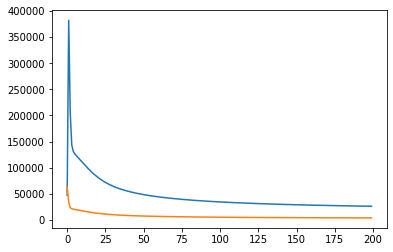

In [28]:
plt.plot(LOSS_tr)
plt.plot(LOSS_val)

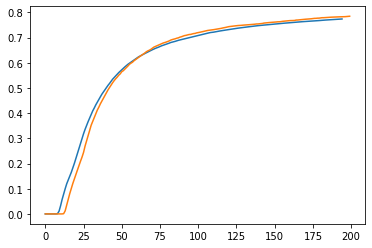

In [29]:
plt.plot(ACC_tr[5:])
plt.plot(ACC_val)

In [30]:
LOSS_val, val_acc = validate(X_val,y_val,one_hot_labels , weights_hidden , bias_hidden , weights_out , bias_out)
print(f"Результирующая точность на валидации - {val_acc}")

Результирующая точность на валидации - 0.7848999999999999
